<a href="https://colab.research.google.com/github/Pumafi/VLG/blob/master/vlso_multiscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Latent Space Optimiser

## Colab Options  
Put the boolean to true if this notebook is running in Google Colab

In [1]:
RUNNING_IN_COLAB = True

if RUNNING_IN_COLAB:
    # Uses a private Auth Token, giving read and write access to repo
    # TO DELETE IF REPO GOES PUBLIC   
    REPO_URL = 'https://028ce9b6b08e7f3d01201e842f8c5faf577e3abd@github.com/Pumafi/flumy-wgan-mines'
    BRANCH   = 'main'
    REPO_DIR = 'flumy-wgan-mines'

    from pathlib import Path

    %cd /content

    if Path(REPO_DIR).is_dir():
      !rm -rf {REPO_DIR}

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone --branch {BRANCH} --depth=1 -- {REPO_URL} {REPO_DIR}
    
    %cd {REPO_DIR}


/content
Cloning into 'flumy-wgan-mines'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 80 (delta 9), reused 41 (delta 4), pack-reused 0
Unpacking objects: 100% (80/80), done.
Checking out files: 100% (63/63), done.
/content/flumy-wgan-mines


## Imports

In [25]:
from tensorflow import keras
from models.load_trained_models import wgan_horizontal, load_msgen_horizontal
from utils.visualisation import *
from data.load_data import load_data, EntropicConditionalDataGenerator
from utils.utils import generate_noise, correct_percentage

from models.conditional_generation.conditional_model_framework import ParametrisationFramework
from models.conditional_generation.parametric_generation_network import NetworkSampling, network_conditional_loss_fn, network_realism_loss
from models.conditional_generation.variational_parametrisation import VariationalSampling, variational_conditional_loss_fn, variational_realism_loss

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Loading pretrained generator

In [26]:
# LOADING MODEL
g_model = load_msgen_horizontal(checkpoint_file="./trainedweights/msgen2dh/cp-gen2d_horizontal_good.ckpt")
g_model.build([None, 8, 16, 1])
g_model.summary()

Model: "multi_scale_generator_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_initial_4 (Genera  multiple                 40        
 torInitial)                                                     
                                                                 
 generator_block_12 (Generat  multiple                 39556     
 orBlock)                                                        
                                                                 
 generator_block_13 (Generat  multiple                 27844     
 orBlock)                                                        
                                                                 
 generator_block_14 (Generat  multiple                 7012      
 orBlock)                                                        
                                                                 
 last_generator_block_4 (Las  multiple     

## Loading the data

In [27]:
# Load Data

from keras.utils.np_utils import to_categorical   


slice_size = (64, 128, 4)
noise_shape = (8, 16, 1)
z = generate_noise(150, 8, 16, 1)
x_generated = g_model(z)[-1].numpy()

x_generated_tmp = np.argmax(x_generated, axis=-1).reshape((-1, 64, 128))
x_generated = to_categorical(x_generated_tmp, num_classes=4)

wells = 15
dataloader = EntropicConditionalDataGenerator(x_generated, 1, slice_size, max_wells=wells, min_wells=wells)

In [28]:
x, msk, y = dataloader.__getitem__(0)
print(x.shape, msk.shape, y.shape)

(1, 64, 128, 4) (1, 64, 128, 1) (1, 64, 128, 4)


## Variational Sampling model and training

In [29]:
e_model = VariationalSampling(noise_shape=(1, 8, 16, 1))

In [30]:
nb_simulations = 100
nb_epochs=4500

parammodel = ParametrisationFramework(e_model, g_model, noise_dims=noise_shape)
parammodel.compile(conditionnal_loss=variational_conditional_loss_fn, realism_loss=variational_realism_loss, optimiser = tf.keras.optimizers.Adam(learning_rate=0.05))

history = parammodel.train_mean_var(x, msk, epochs=nb_epochs, nb_simulations=nb_simulations)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.05>


  0%|          | 0/4500 [00:00<?, ?it/s]

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.025>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0125>


## Training Visualisations

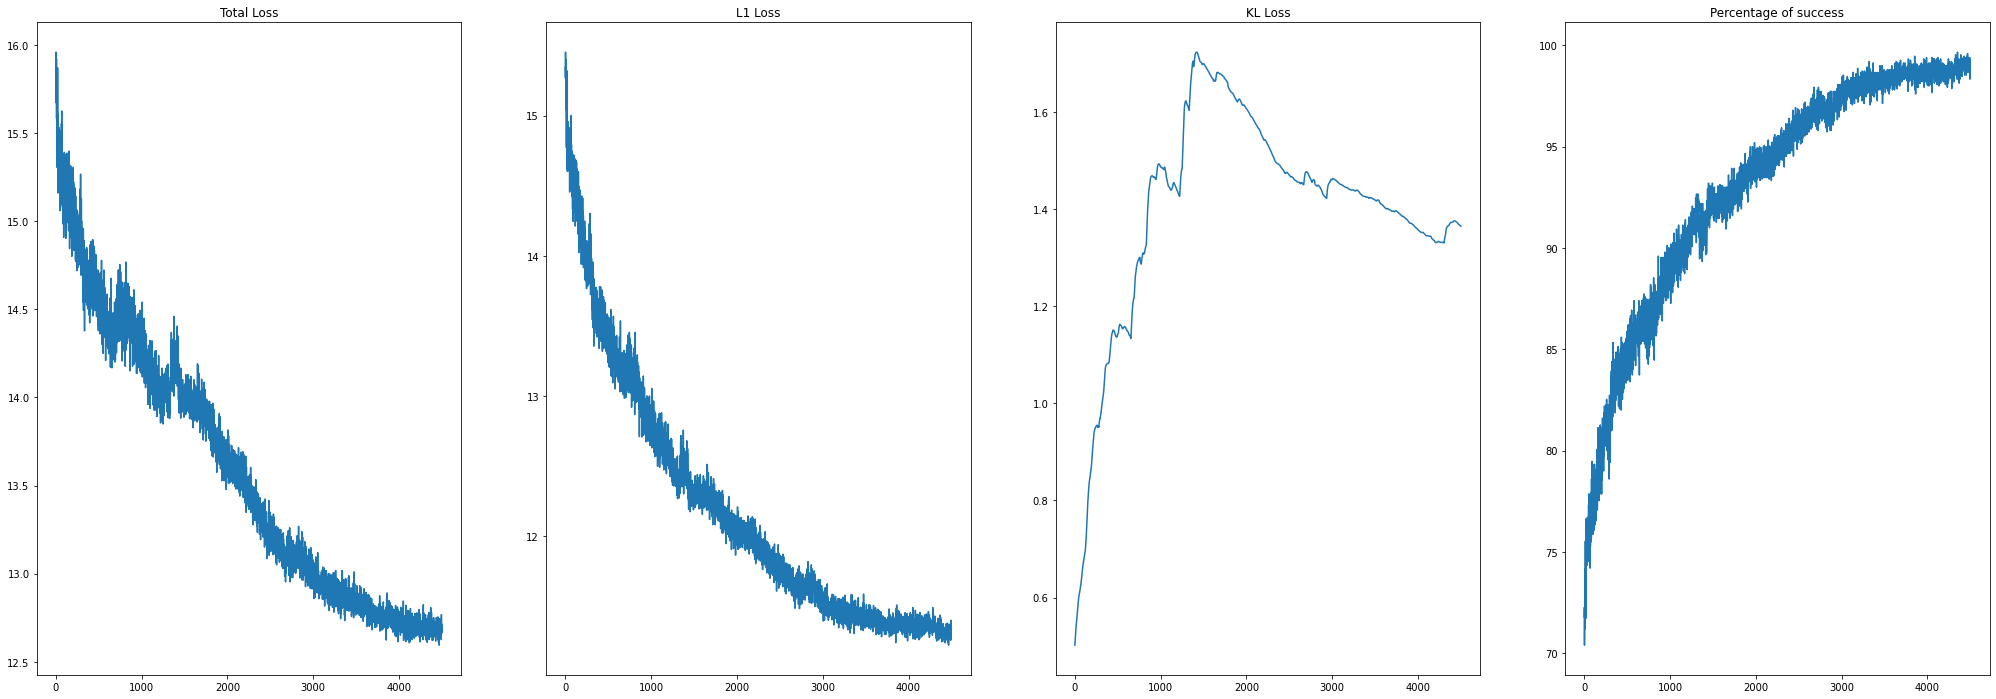

In [31]:
x_axis = np.arange(nb_epochs)
plt.figure(figsize=(35, 12))
plt.subplot(1, 4, 1)
plt.title("Total Loss")
plt.plot(x_axis, history["total loss"])
plt.subplot(1, 4, 2)
plt.title("L1 Loss")
plt.plot(x_axis, history["conditional loss"])
plt.subplot(1, 4, 3)
plt.title("KL Loss")
plt.plot(x_axis, history["realism loss"])
plt.subplot(1, 4, 4)
plt.title("Percentage of success")
plt.plot(x_axis, history["correct percentage"])
plt.show()

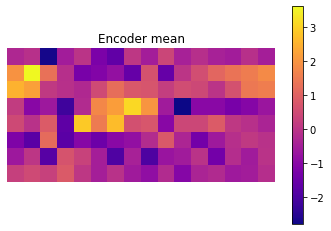

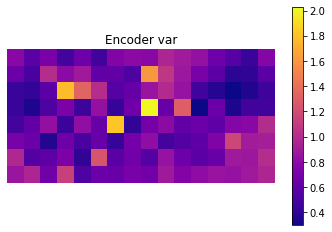

In [32]:
parammodel.print_parameters()

## Generating new images and visualisation

In [33]:
generated_images = parammodel.generate_images(nb_simulations=100)
generated_images.shape

TensorShape([100, 64, 128, 4])

In [34]:
with open('vlso.npy', 'wb') as f:
    np.save(f, generated_images)

In [35]:
generated_images = parammodel.generate_images(nb_simulations=2000)
correct_percentage(generated_images, y, msk, print_res=True)

Percentage of successful predictions 99.00%:


99.0

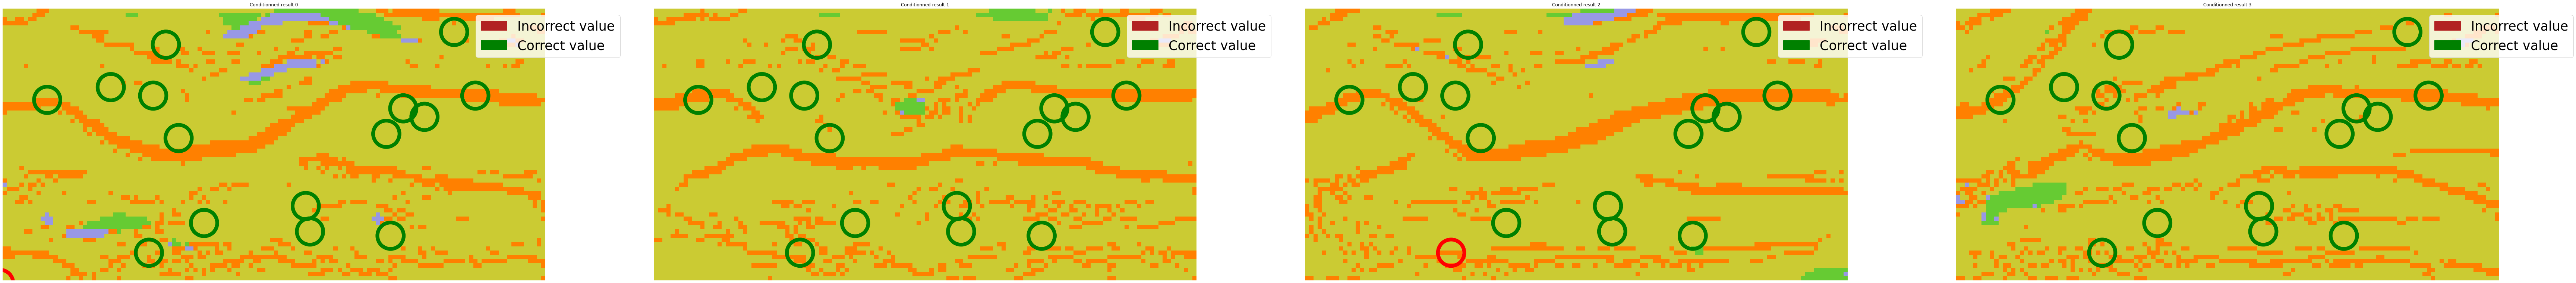

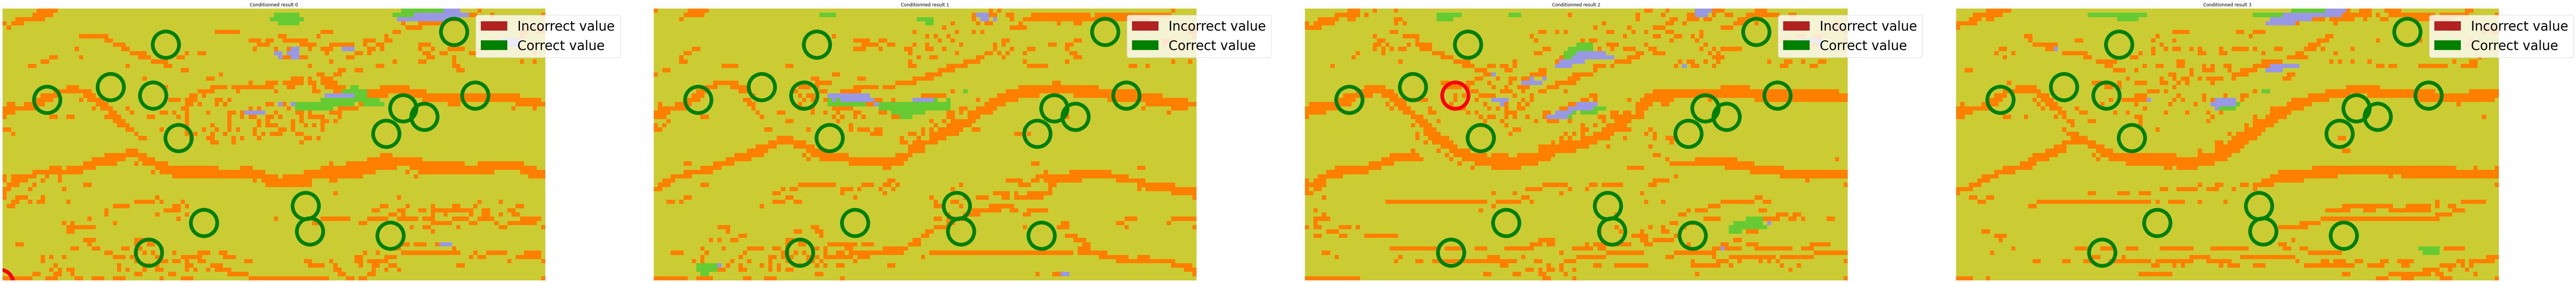

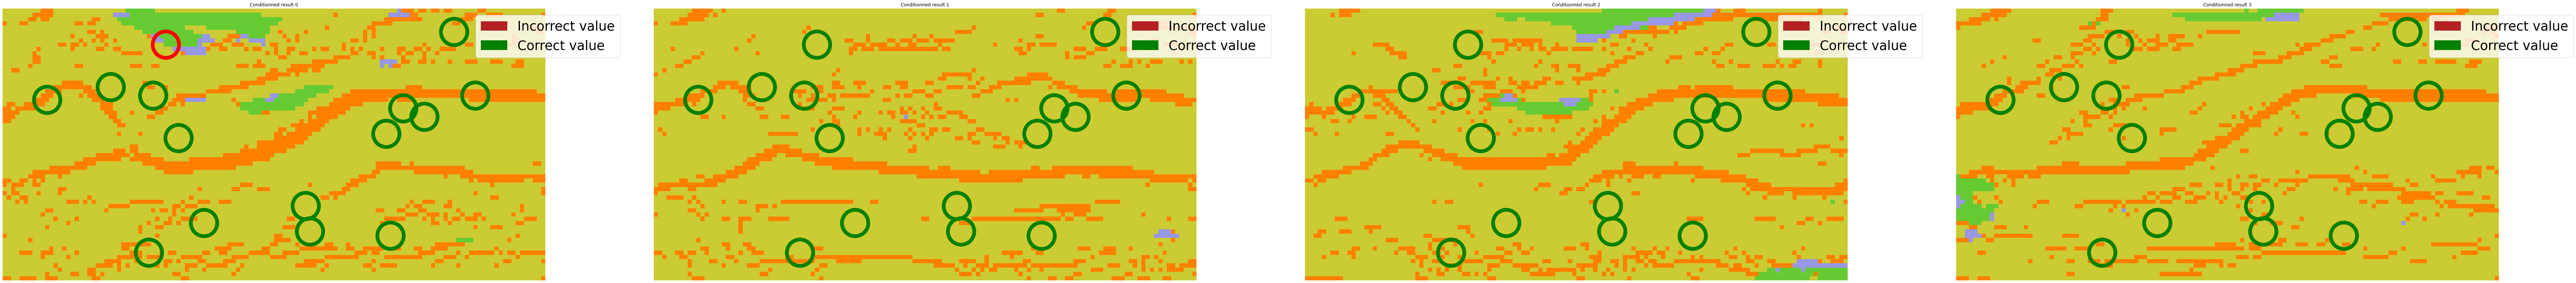

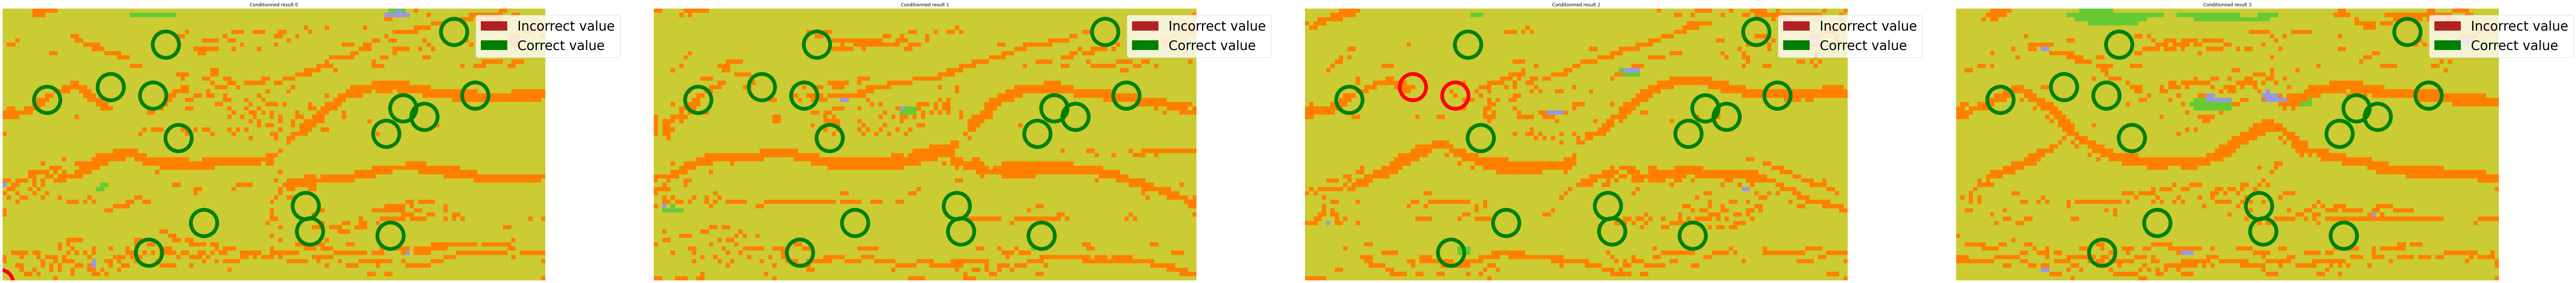

In [36]:
nb_simulations = 4
cmap, norm = get_color_map(number_of_categories=4)

for i in range(4):
  generated_images = parammodel.generate_images(nb_simulations=nb_simulations)
  print_conditioned_results(x, generated_images, msk, nb_simulations, cmap, norm)


In [37]:
generated_images = parammodel.generate_images(nb_simulations=500)

proba_map, most_probable_facies = compute_probability_map(generated_images)
real_proba_map, real_most_probable_facies = compute_probability_map(y)
print(proba_map.shape, most_probable_facies.shape)

(64, 128, 4) (64, 128)


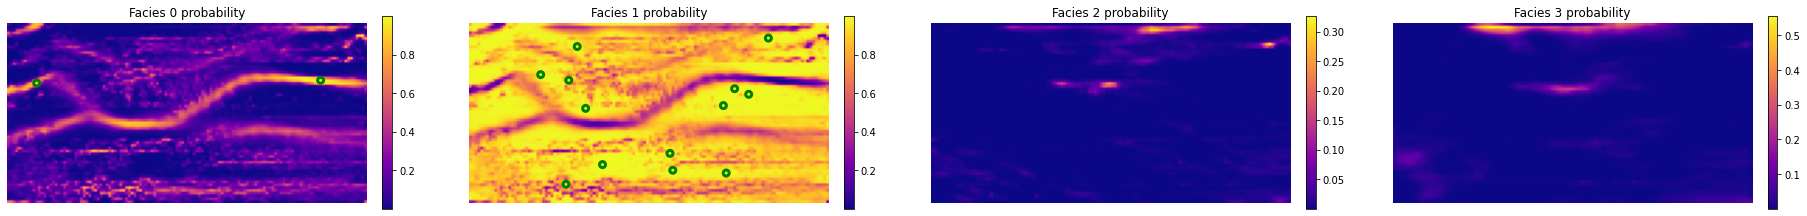

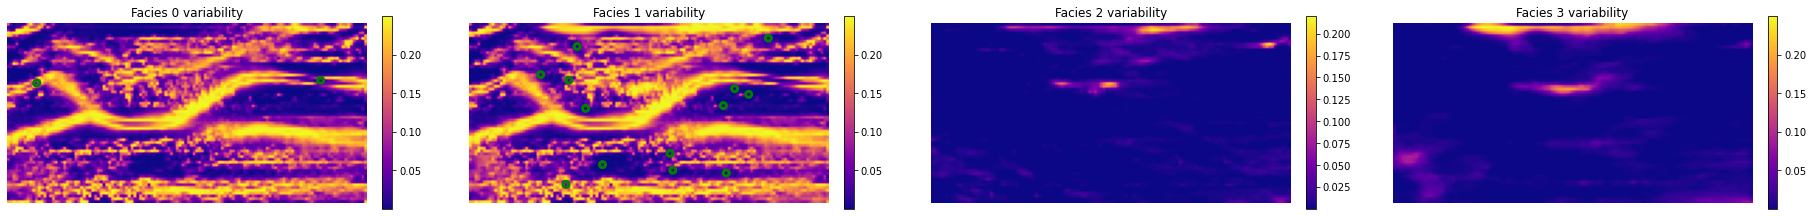

In [38]:
print_proba_map(proba_map, cmap, norm, samples=x)
print_proba_map(proba_map, cmap, norm, samples=x, plot_variance=True)

#print_proba_map(real_proba_map, real_most_probable_facies, cmap, norm)

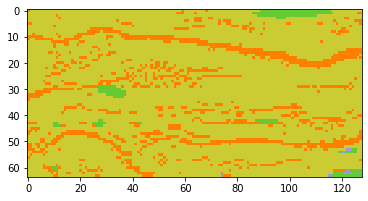

In [39]:
y_interpolated1 = np.argmax(y, axis=-1).reshape((64, 128))
plt.imshow(y_interpolated1, interpolation='nearest', cmap=cmap, norm=norm)

## Parametric Generation using an Inference DL network

In [46]:
nb_simulations = 100
nb_epochs=10000

network_model = NetworkSampling()
parammodel = ParametrisationFramework(network_model, g_model, noise_dims=noise_shape)
parammodel.compile(conditionnal_loss=network_conditional_loss_fn, realism_loss=network_realism_loss, optimiser = tf.keras.optimizers.Adam(learning_rate=0.016))
history = parammodel.train_mean_var(x, msk, epochs=nb_epochs, nb_simulations=nb_simulations, lr_decay_epoch=2000)

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.016>


  0%|          | 0/10000 [00:00<?, ?it/s]

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.008>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.004>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.002>
<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


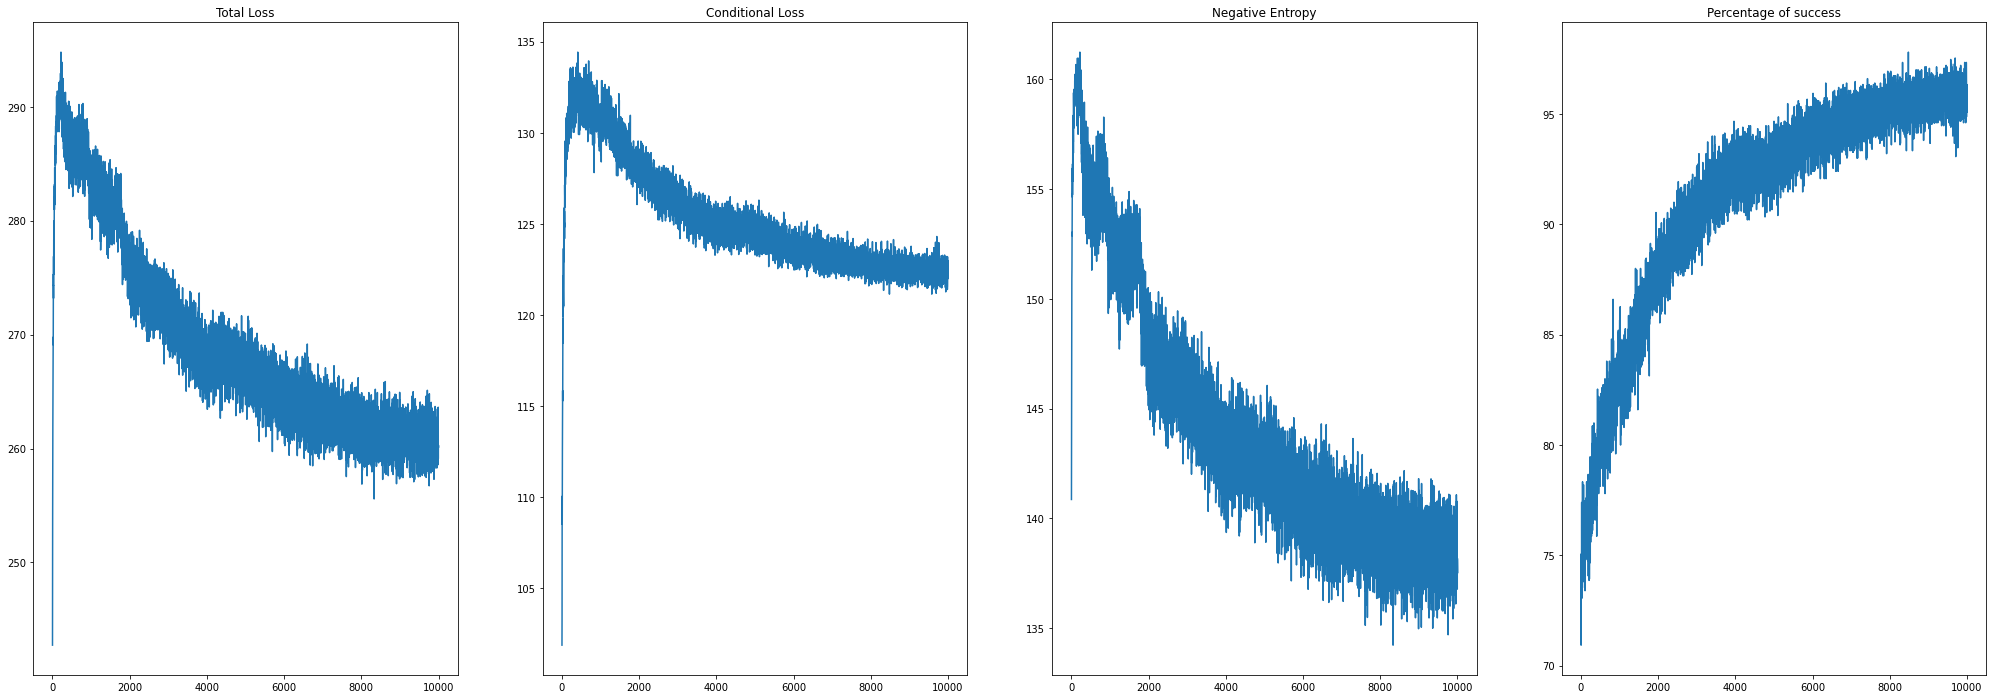

In [47]:
x_axis = np.arange(nb_epochs)
plt.figure(figsize=(35, 12))
plt.subplot(1, 4, 1)
plt.title("Total Loss")
plt.plot(x_axis, history["total loss"])
plt.subplot(1, 4, 2)
plt.title("Conditional Loss")
plt.plot(x_axis, history["conditional loss"])
plt.subplot(1, 4, 3)
plt.title("Negative Entropy")
plt.plot(x_axis, history["realism loss"])
plt.subplot(1, 4, 4)
plt.title("Percentage of success")
plt.plot(x_axis, history["correct percentage"])
plt.show()

In [48]:
generated_images = parammodel.generate_images(nb_simulations=2000)
correct_percentage(generated_images, y, msk, print_res=True)

Percentage of successful predictions 95.89%:


95.88666666666667

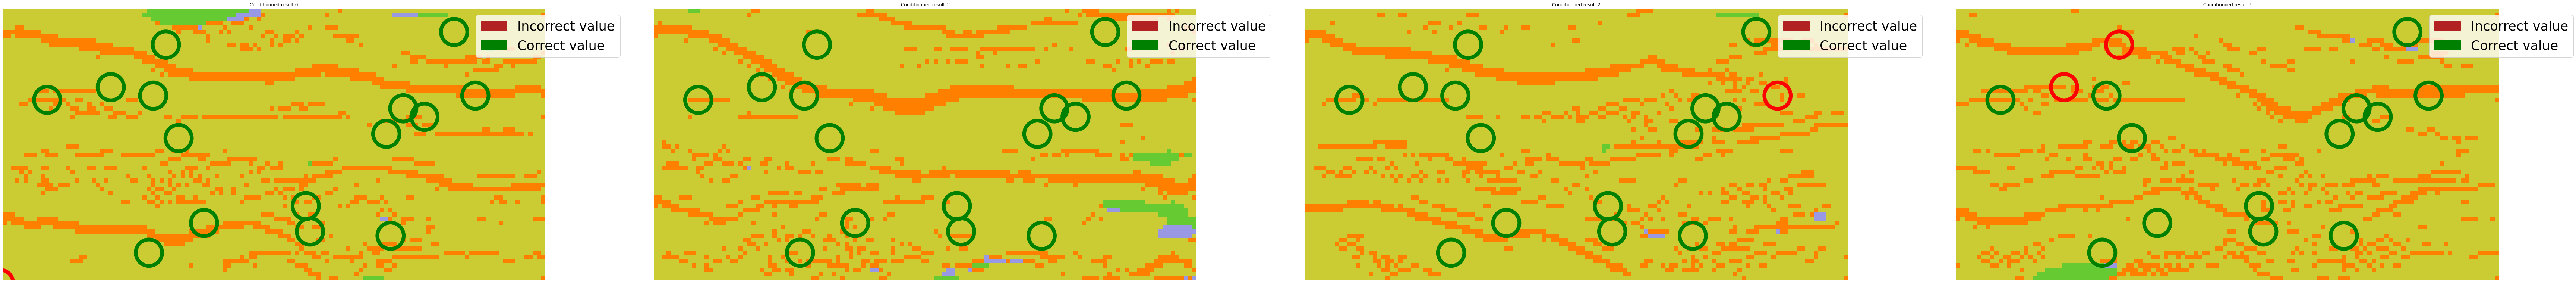

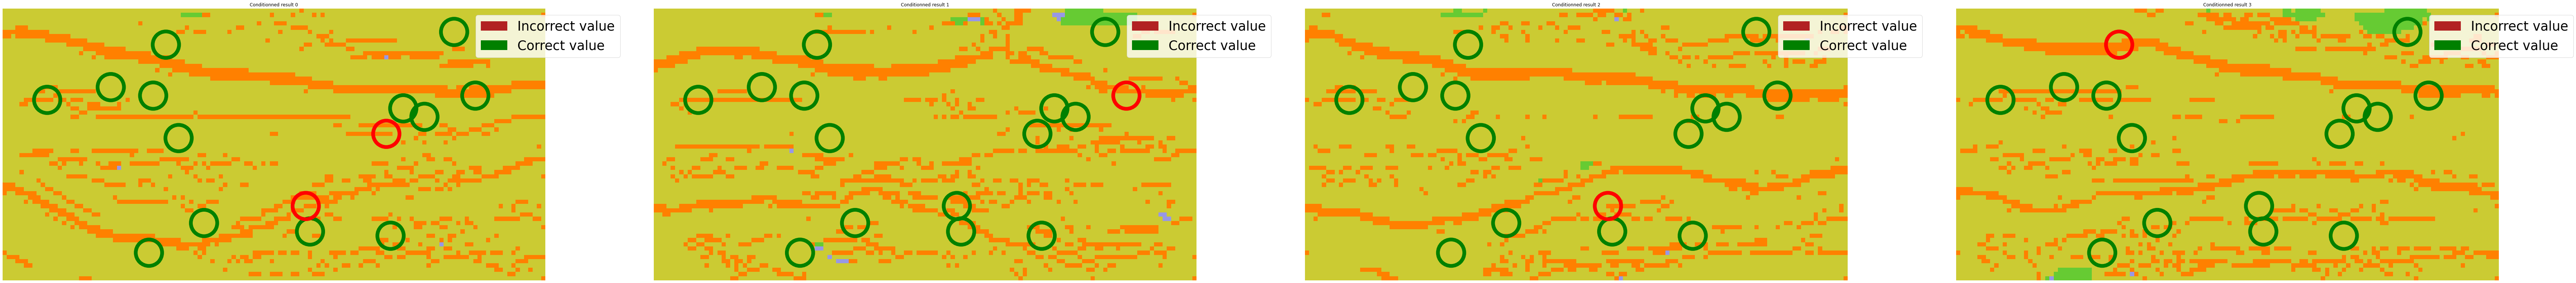

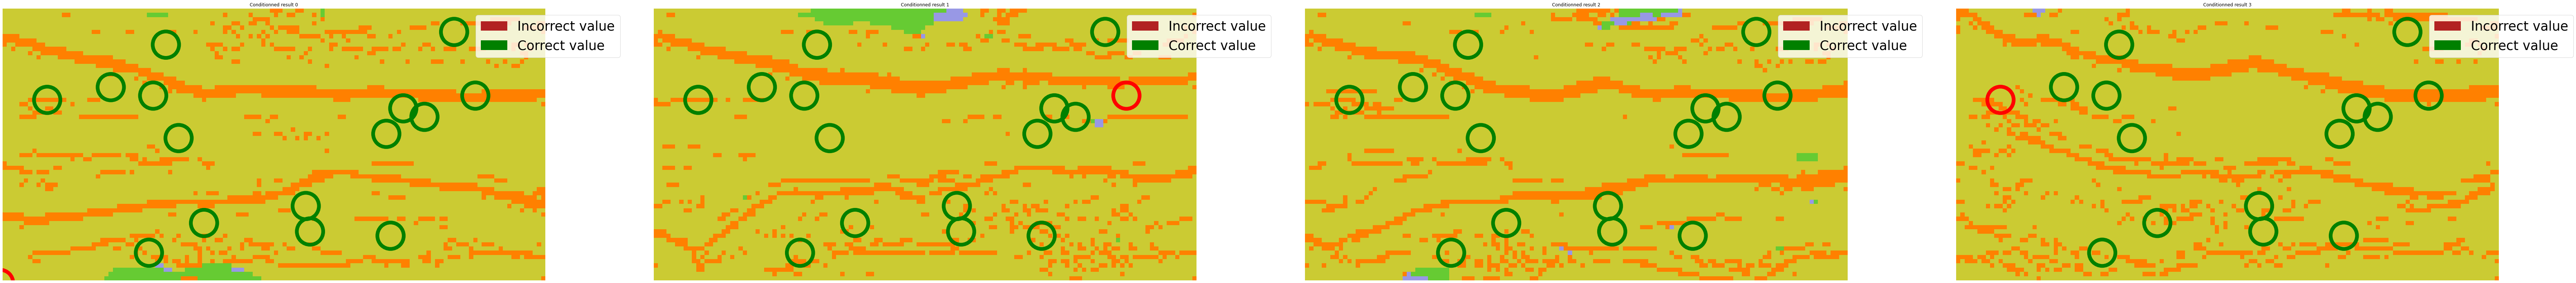

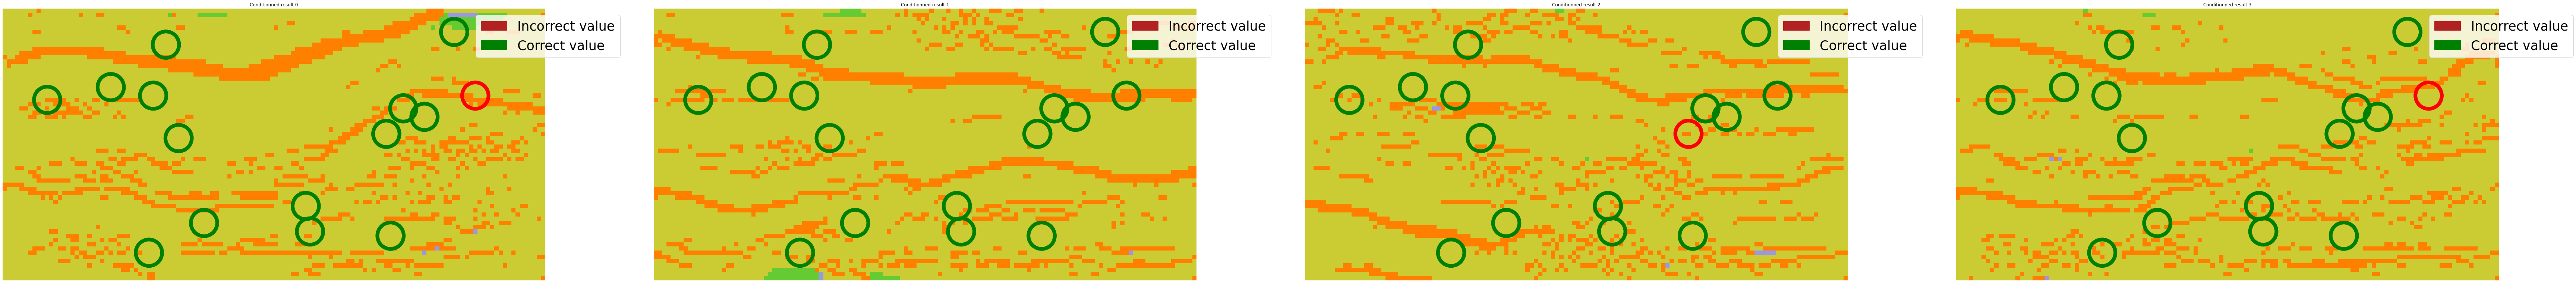

In [49]:
nb_simulations = 4
cmap, norm = get_color_map(number_of_categories=4)

for i in range(4):
  generated_images = parammodel.generate_images(nb_simulations=nb_simulations)
  print_conditioned_results(x, generated_images, msk, nb_simulations, cmap, norm)


In [50]:
generated_images = parammodel.generate_images(nb_simulations=500)

proba_map, most_probable_facies = compute_probability_map(generated_images)
real_proba_map, real_most_probable_facies = compute_probability_map(y)
print(proba_map.shape, most_probable_facies.shape)

(64, 128, 4) (64, 128)


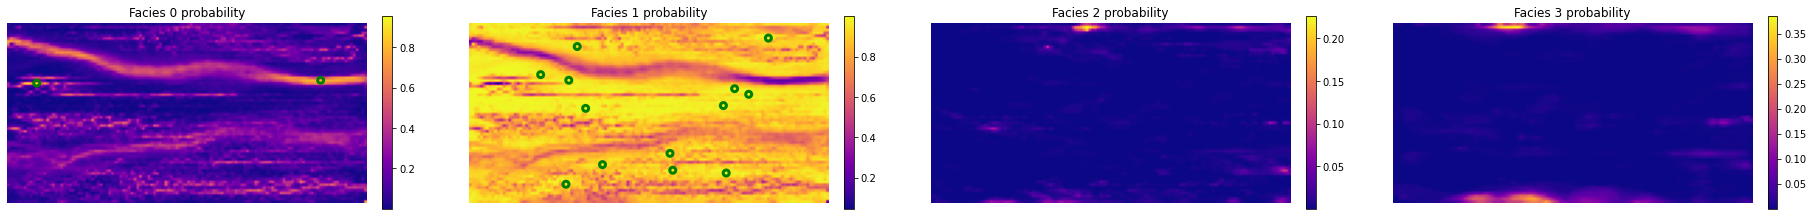

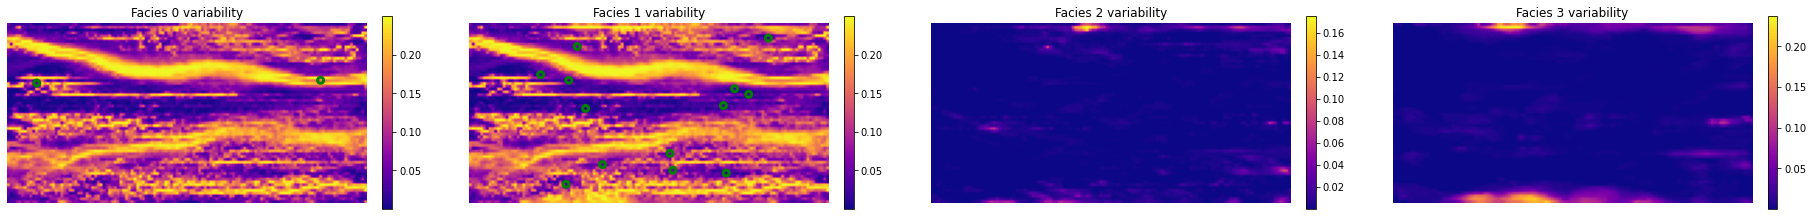

In [51]:
print_proba_map(proba_map, cmap, norm, samples=x)
print_proba_map(proba_map, cmap, norm, samples=x, plot_variance=True)

#print_proba_map(real_proba_map, real_most_probable_facies, cmap, norm)

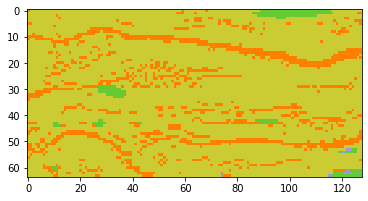

In [52]:
y_interpolated1 = np.argmax(y, axis=-1).reshape((64, 128))
plt.imshow(y_interpolated1, interpolation='nearest', cmap=cmap, norm=norm)